# easy21

My interpretation of the easy21 problem posed by David Silver for reinforcement learning. The script uses an $epsilon$-greedy algorithm using first an MC exploration, then a SARSA-$\lambda$ implementation then finally a linear function approximation to solve the easy21 assignment set by David Silver. 

### Game rules

The goal of this assignment is to apply reinforcement learning methods to a
simple card game that we call Easy21. This exercise is similar to the Blackjack
example in Sutton and Barto 5.3 – please note, however, that the rules of the
card game are different and non-standard.
- The game is played with an infinite deck of cards (i.e. cards are sampled
with replacement)
- Each draw from the deck results in a value between 1 and 10 (uniformly
distributed) with a colour of red (probability 1/3) or black (probability
2/3).
- There are no aces or picture (face) cards in this game
- At the start of the game both the player and the dealer draw one black
card (fully observed)
- Each turn the player may either stick or hit
- If the player hits then she draws another card from the deck
- If the player sticks she receives no further cards
- The values of the player’s cards are added (black cards) or subtracted (red
cards)
- If the player’s sum exceeds 21, or becomes less than 1, then she “goes
bust” and loses the game (reward -1)
- If the player sticks then the dealer starts taking turns. The dealer always
sticks on any sum of 17 or greater, and hits otherwise. If the dealer goes
bust, then the player wins; otherwise, the outcome – win (reward +1),
lose (reward -1), or draw (reward 0) – is the player with the largest sum.

In [1]:
# required Python libraries
import pandas as pd
import random    

# functionality to plot up the states
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np

### 1. Implementation of easy21

You should write an environment that implements the game Easy21. Specifically, write a function, named step, which takes as input a state s (dealer’s first
card 1–10 and the player’s sum 1–21), and an action a (hit or stick), and returns
a sample of the next state s
0
(which may be terminal if the game is finished)
and reward $r$. We will be using this environment for model-free reinforcement
learning, and you should not explicitly represent the transition matrix for the
MDP. There is no discounting ($\gamma$ = 1). You should treat the dealer’s moves as
part of the environment, i.e. calling step with a stick action will play out the
dealer’s cards and return the final reward and terminal state.

In [2]:
def initialise_states(epsilon = None, alpha = None):
    """
    Initialise all possible states (player's cards 1-21 and dealer's cards 1-10).
    
    Parameters:
    -----------
    epsilon: epsilon value
    
    alpha: update rate value. 
    
    Returns:
    --------
    states: dictionary of all states in the game.
    """
    states = {}
    for dealer_state in range(1, 11):
        for player_state in range(1, 22):
            states[(player_state, dealer_state)] = State(player_state, dealer_state,
                                                         epsilon, alpha)
    
    return states


def generate_random_card():
    """
    Generate a random card from the deck. 
    
    Returns:
    --------
    card_value: value of the generated card.
    """
    card_value = random.randint(1, 10)
    # get a card colour
    card_colour = random.uniform(0, 1) > (1/3)
    if card_colour == 0:
        card_value *= -1
    return card_value


class State():
    def __init__(self, player_sum, dealer_sum, epsilon=None, alpha=None):
        """
        Class for keeping track the status of each state of the game.
        This keeps track of all eligibility traces, Q-values and the 
        number of times each state is visited.
        
        Parameters:
        -----------
        player_sum: total sum of the player's hand.
        
        dealer_sum: total sum of the dealer's hand.
        
        epsilon: exploration/exploitation factor. If None supplied,
        then the default set in the question is used.
        
        alpha: update factor. If None supplied,then the default set in 
        the question is used.
        
        Attributes:
        -----------
        generate_action: generate an epsilon-greedy action from the 
        current state. 
        
        update_state_MC: update the states after MC episode.
        
        update_state_SARSA: update the states in SARSA-lambda control.
        
        update_eligibility_traces: update the eligibility traces in 
        SARSA-lambda control.
        
        reset_eligiblity_traces: reset the eligiblity traces after
        SARSA-lambda episode.
        """
        # initial values
        self.player_sum = player_sum
        self.dealer_sum = dealer_sum

        # number of times we have taken an action from this state
        self.N_a_stick = 0
        self.N_a_hit = 0
        
        # value functions
        self.Q_hit = 0
        self.Q_stick = 0
        
        # eligibility traces
        self.E_hit = 0
        self.E_stick = 0
        
        # main parameters for exploaration/updates
        self.epsilon = epsilon
        self.alpha = alpha
        
    def generate_action(self, N0=100):
        """
        Generate either a 'hit' or 'stick' action. 
        
        Parameters:
        -----------
        N0: value used for calculating epsilon (epsilon = N0 / (N0 + N_s)).
        
        Returns:
        --------
        a: an action -- either 'hit' or 'stick'.
        """
        # generate action based on epsilon-greedy 
        epsilon = N0 / (N0 + self.N_a_stick + self.N_a_hit)
        random_value = random.uniform(0, 1)
        
        if random_value <= epsilon:
            a = random.choice(["hit", "stick"])
        else:
            if self.Q_stick > self.Q_hit:
                a = "stick"
            elif self.Q_hit > self.Q_stick:
                a = "hit"
            else:
                a = random.choice(["hit", "stick"])
            
        return a
    
    def update_state_MC(self, a, Q):
        """
        After a full episode, update the state.
        
        Parameters:
        -----------
        a: action that was taken from the state.
        
        Q: final value function achieved. 
        """
        # update the state after a MC run, given a value + action taken
        if a == "stick":
            self.N_a_stick += 1
            alpha = (1/self.N_a_stick) if self.alpha is None else self.alpha
            # update average incrementally
            self.Q_stick += alpha * (Q - self.Q_stick)
        else:
            self.N_a_hit += 1
            alpha = (1/self.N_a_hit) if self.alpha is None else self.alpha
            # update average incrementally
            self.Q_hit += alpha * (Q - self.Q_hit)
                
        return None
    
    def update_state_SARSA(self, a, delta):
        """
        Update the state during a SARSA episode.
        
        Parameters:
        -----------
        a: action that was taken from the state.
        
        delta: delta value calculated for the SARSA-lambda update.
        """
        if a == "stick":
            self.N_a_stick += 1
            self.E_stick += 1
            alpha = (1/self.N_a_stick) if self.alpha is None else self.alpha
            self.Q_stick += self.E_stick * alpha * delta
        else:
            self.N_a_hit += 1
            self.E_hit += 1
            alpha = (1/self.N_a_hit) if self.alpha is None else self.alpha
            self.Q_hit += self.E_hit * alpha * delta
        
        return None
    
    def update_eligibility_traces(self, lambda_):
        """
        Update the eligibility traces after each visit.
        """
        self.E_hit *= lambda_
        self.E_stick *= lambda_
        return None
    
    def reset_eligibility_traces(self):
        """
        Reset the eligibility traces after completion of a full episode.
        """
        self.E_hit = 0
        self.E_stick = 0
        return None
    
    
def step(s, a, states):
    """
    Play out an action from a state. Given a state, s, and 
    an action, a, play out what happens (either enter a new 
    state or play out the rest of the game if we enter a terminal
    state).
    
    Parameters:
    -----------
    s: the state we are currently in.
    
    a: action taken from the state.
    
    states: dictionary of all possible states in the game.
    
    Returns:
    --------
    s: state after the action has been taken. s = None if the state 
    is terminal.
    
    r: reward for taking the action from the state.
    """
    
    # enter a new state if we decide to hit
    if a is "hit":
        # enter new state
        new_player_card = generate_random_card()
        new_player_sum = s.player_sum + new_player_card
        # get reward of the state-action pair
        if (1 <= new_player_sum <= 21) is False:
            r = -1
            s = None
        else:
            r = 0
            # enter the new state
            s = states[new_player_sum, s.dealer_sum]
    
    # play out the dealer's turn if we decide to stick
    else: 
        # enter terminal state
        dealer_sum = s.dealer_sum
        player_sum = s.player_sum
        s = None
        
        while (1 <= dealer_sum <= 17):
            new_dealer_card = generate_random_card()
            dealer_sum += new_dealer_card
        
        # check our results vs. dealer's once episode has played out
        if (1 <= dealer_sum <= 21) is False:
            r = 1
        elif player_sum > dealer_sum:
            r = 1
        elif dealer_sum > player_sum:
            r = -1
        else:
            r = 0
    
    return s, r


def update_states_MC(states, state_action_pairs, Q):
    """
    Update all of the states after an MC episode.
    
    Parameters:
    -----------
    states: list of all possible states in the game.
    
    state_action_pairs: list of states and actions that 
    were visited in the MC episode.
    
    Q: final value of the MC episode.
    
    Returns:
    --------
    states: updated states.
    """
    
    for player_sum, dealer_sum, a in state_action_pairs: 
        states[(player_sum, dealer_sum)].update_state_MC(a, Q)
        
    return states


def update_states_SARSA(states, state_action_pairs, delta):
    """
    Update states during a SARSA-lambda episode.
    
    Parameters:
    -----------
    states: dictionary of all possible states in the game.
    
    state_action_pairs: list of states and actions that were 
    visited in the game.
    
    delta: SARSA-lambda update value.
    
    Returns:
    --------
    states: updated dictionary of states.
    """
    
    for player_sum, dealer_sum, a in state_action_pairs: 
        states[(player_sum, dealer_sum)].update_state_SARSA(a, delta)
        
    return states


def update_eligibility_traces(states, lambda_):
    """
    Update all of the eligibility traces during SARSA-lambda.
    
    Parameters:
    -----------
    states: dictionary of all of the states.
    
    lambda_: lambda value for SARSA-lambda.
    
    Returns:
    --------
    states: states with updated SARSA-lambda values.    
    """
    # update _all_ eligibility traces
    for player_sum in range(1, 22):
        for dealer_sum in range(1, 11):
            states[(player_sum, dealer_sum)].update_eligibility_traces(lambda_)
        
    return states


def reset_eligibility_traces(states):
    """
    Reset all of the eligibility traces to 0.
    
    Parameters:
    -----------
    states : dictionary of all of the states in the game.
    
    Returns:
    --------
    states: initial states with reset eligiblity traces.
    """
    for player_sum in range(1, 22):
        for dealer_sum in range(1, 11):
            states[(player_sum, dealer_sum)].reset_eligibility_traces()
            
    return states


def play_full_episode(states):
    """
    Play a full random episode of blackjack.
    
    Parameters:
    -----------
    states: dictionary of all possible states.
    
    Returns:
    --------
    states: states updated after the completion of an episode.
    """
    
    # set up random initial state
    player_card = random.randint(1, 10)
    dealer_card = random.randint(1, 10)
    s = states[(player_card, dealer_card)]
    
    # create list to record all of the states/action pairs we used
    state_action_pairs = []
    
    while s is not None:
        a = s.generate_action()
        # record the action
        state_action_pairs.append((s.player_sum, s.dealer_sum, a))
        s, r = step(s, a, states)
    
    return r, state_action_pairs, states


def play_SARSA_episode(states, lambda_ = .1):
    """
    Play a SARSA-lambda episode of blackjack.
    
    Parameters:
    -----------
    states: dictionary of all possible states.
    
    Returns:
    --------
    states: states updated after the completion of an episode.
    """
    # Play a TD episode of blackjack (updates after each Q)
    
    # set up the random initial state
    player_card = random.randint(1, 10)
    dealer_card = random.randint(1, 10)
    s = states[(player_card, dealer_card)]
    
    # generate a starting action (so we start with SA)
    a = s.generate_action()
    state_action_pairs = []
    
    while s is not None:
        # get value of the current state
        state_action_pairs.append((s.player_sum, s.dealer_sum, a))
        Q = s.Q_hit if a == "hit" else s.Q_stick
        
        # enter new state from current action
        s_new, r = step(s, a, states)
        # action for non-terminal states
        if s_new is not None:
            a_new = s_new.generate_action()
            Q_new = s_new.Q_hit if a_new == "hit" else s_new.Q_stick
        else:
            Q_new = 0
            
        # update SARSA states
        delta = r + Q_new - Q
        states = update_eligibility_traces(states, lambda_)
        states = update_states_SARSA(states, state_action_pairs, delta)
        
        # change the current state to the new state
        if s_new is not None:
            s = s_new
            a = a_new
        else:
            s = s_new
    
    return states


def play_MC_blackjack(N = 10**5, states=None):
    """
    Play the blackjack game using MC-control.
    
    Parameters:
    -----------
    N: number of games to play.
    
    states: states of the game. If None, then states
    will be initialised from scratch.
    
    Returns:
    --------
    states: final states after all MC updates.
    """
    
    if states is None:
        states = initialise_states()
    
    for n in range(N):
        r, state_action_pairs, states = play_full_episode(states)
        update_states_MC(states, state_action_pairs, r)
        
    return states


def play_SARSA_blackjack(N = 1000, lambda_ = .1, states=None):
    """
    Play the blackjack game using SARSA-lambda control.
    
    Parameters:
    -----------
    N: number of games to play.
    
    lambda_: lambda value for the SARSA-lambda algorithm
    
    states: states of the game. If None, then states
    will be initialised from scratch.
    
    Returns:
    --------
    states: final states after all SARSA-lambda updates.
    """
    
    assert 0 <= lambda_ <= 1, (
        "lambda_ term in SARSA(lambda) routine must be between 0 and 1")
    if states is None:
        states = initialise_states()
    
    for n in range(N):
        states = play_SARSA_episode(states)
        # reset eligibility counter to 0
        states = reset_eligibility_traces(states)
                
    return states

In [3]:
class StatesPlotter():
    def __init__(self, states):
        """
        Functionality for plotting up the values of the 
        final states of reinforcement learning easy21
        control. Can be used to plot up value funtions
        of each state.
        
        Parameters:
        -----------
        states: trained states from either the MC or the 
        SARSA-lambda game.
        
        Attributes:
        -----------
        plot_value_function: plot up the value funtion of 
        all of the states.
        """
        
        self.Q = []
        self.a = []
        self.x = []
        self.y = []
        
        for dealer_sum in range(1, 11):
            for player_sum in range(1, 22):
                self.x.append(dealer_sum)
                self.y.append(player_sum)
                s = states[(player_sum, dealer_sum)]
                best_Q = max([s.Q_hit, s.Q_stick])
                best_a = 1 if s.Q_hit > s.Q_stick else 0
                self.Q.append(best_Q)
                self.a.append(best_a)
        
        self.Q = np.array(self.Q).reshape(10, 21)
        self.a = np.array(self.a).reshape(10, 21)
        self.x = np.array(self.x).reshape(10, 21)
        self.y = np.array(self.y).reshape(10, 21)
        
    def plot_value_function(self):
        """
        plot the value functions of all states. 
        """
        
        # create 3d figure instance
        fig = plt.figure(figsize=(10, 10))
        ax = fig.gca(projection="3d")
        
        _ = ax.plot_surface(self.x, self.y, self.Q,
                            cmap="viridis", rstride=1, cstride=1,
                            edgecolors="k")
        
        _ = ax.set_xlabel("Dealer's card value", fontsize=15)
        _ = ax.set_ylabel("Player's card(s) value", fontsize=15)
        _ = ax.set_zlabel("$V_*$", fontsize=15)
        
        _ = ax.set_xticks(range(1, 11))
        _ = ax.set_yticks(range(1, 22, 2))
        
        return fig, ax
    
    
def compare_state_values(states, true_states):
    """
    Calculate the error compared to the true value.
    
    Parameters:
    -----------
    states: states from training.
    
    true_states: true values to compare to.
    """
    
    V_error = 0
    
    for player_sum in range(1, 21):
        for dealer_sum in range(1, 11):
            s = states[(player_sum, dealer_sum)]
            s_true = true_states[(player_sum, dealer_sum)]
            V_error += (s_true.Q_hit - s.Q_hit) ** 2
            V_error += (s_true.Q_hit - s.Q_hit) ** 2
            
    return V_error

### 2. Monte-Carlo Control in Easy21

Apply Monte-Carlo control to Easy21. Initialise the value function to zero. Use
a time-varying scalar step-size of αt = 1/N(st, at) and an $\epsilon$-greedy exploration
strategy with $\epsilon_t = N_0/(N_0 + N(s_t))$, where $N_0 = 100$ is a constant, $N(s)$ is
the number of times that state s has been visited, and $N(s, a)$ is the number
of times that action a has been selected from state $s$. Feel free to choose an
alternative value for $N_0$, if it helps producing better results. Plot the optimal
value function $V^*(s) = \max_a Q^*(s, a)$ using similar axes to the following figure
taken from Sutton and Barto’s Blackjack example.

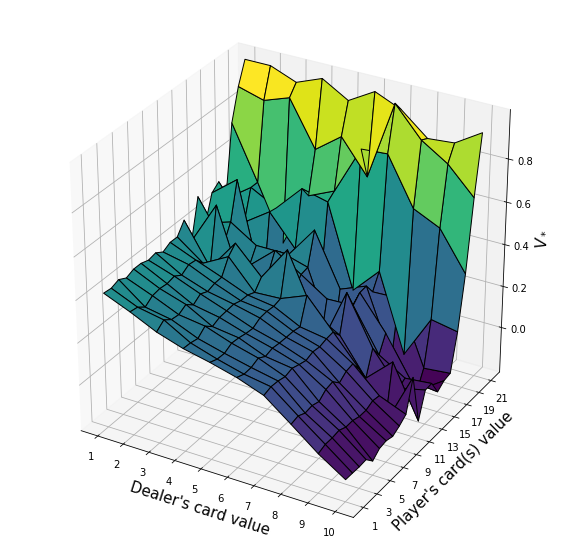

In [4]:
random.seed(0)

# play MC events
MC_states = play_MC_blackjack(10 ** 6)

# plot up results
plotter = StatesPlotter(MC_states)
_ = plotter.plot_value_function()

### 3. TD Learning in Easy21

Implement Sarsa($\lambda$) in 21s. Initialise the value function to zero. Use the same step-size and exploration schedules as in the previous section. Run the algorithm with parameter values $\lambda \in$ {0, 0.1, 0.2, ..., 1}. Stop each run after 1000 episodes and report the mean-squared error $\sum_{s,a} (Q(s, a) − Q^*(s, a))^2$ over all states $s$ and actions $a$, comparing the true values $Q^∗ (s, a)$ computed in the previous section with the estimated values $Q(s, a)$ computed by Sarsa. Plot the mean-squared error against $\lambda$. For $\lambda = 0$ and $\lambda = 1$ only, plot the learning curve of
mean-squared error against episode number.


In [5]:
random.seed(0)

lambdas = np.arange(0.0, 1.1, 0.1)
results_df = pd.DataFrame()

# cycle through values of lambda
for lambda_ in lambdas:
    SARSA_states = initialise_states()
    # play episodes in batches of 1000
    for n in range(10):
        SARSA_states = play_SARSA_blackjack(N = 1000, lambda_ = lambda_, states = SARSA_states)
        error = compare_state_values(SARSA_states, MC_states)
        results_df.loc[lambda_, str(n * 1000)] = error

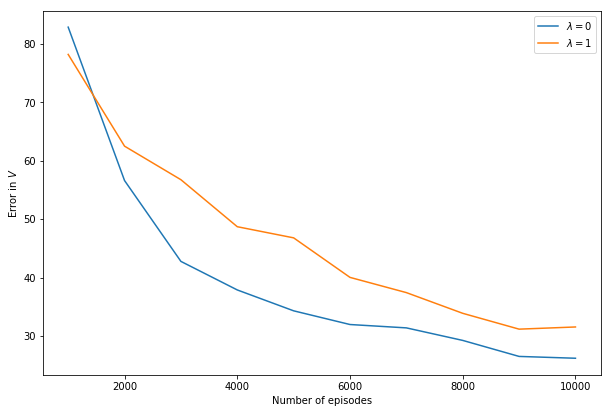

In [6]:
# plot up learning curves
fig, ax = plt.subplots(1, 1, figsize=(10, 6.7))

for lambda_ in (0, 1):
    x = np.arange(1000, 11000, 1000)
    y = results_df.loc[lambda_, :].tolist()
    _ = ax.plot(x, y, label = f"$\lambda = {round(lambda_, 1)}$")
    
_ = ax.legend()
_ = ax.set_xlabel("Number of episodes")
_ = ax.set_ylabel("Error in $V$")

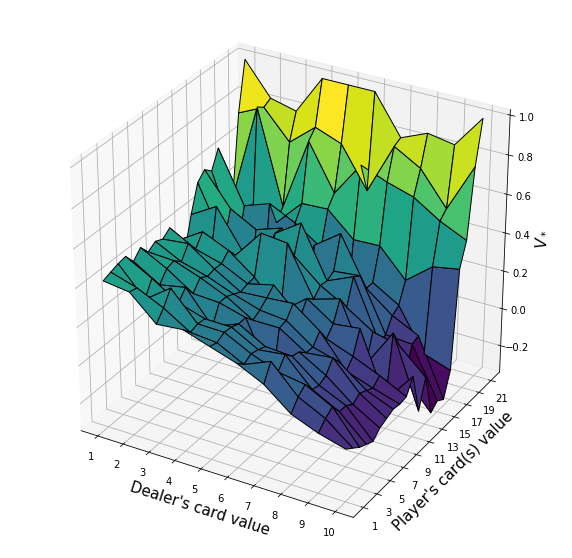

In [7]:
# run full SARSA for lambda = 0.1
random.seed(0)

# play MC events
SARSA_states = play_SARSA_blackjack(10 ** 5)

# plot up results
plotter = StatesPlotter(SARSA_states)
_ = plotter.plot_value_function()

### 4. Linear Function Approximation in Easy21

We now consider a simple value function approximator using coarse coding. Use a binary feature vector φ(s, a) with 3 ∗ 6 ∗ 2 = 36 features. Each binary feature has a value of 1 iff (s, a) lies within the cuboid of state-space corresponding to that feature, and the action corresponding to that feature. The cuboids have the following overlapping intervals:

- dealer(s) = {[1, 4], [4, 7], [7, 10]}
- player(s) = {[1, 6], [4, 9], [7, 12], [10, 15], [13, 18], [16, 21]}
- a = {hit, stick}

where
 - dealer(s) is the value of the dealer’s first card (1–10)
 - sum(s) is the sum of the player’s cards (1–21)

Repeat the Sarsa($\lambda$) experiment from the previous section, but using linear value function approximation $Q(s, a) = \phi(s, a)^T \phi$. Use a constant exploration of $\epsilon = 0.05$ and a constant step-size of 0.01. Plot the mean-squared error against $\lambda$. For $\lambda = 0$ and $\lambda = 1$ only, plot the learning curve of mean-squared error against episode number.

In [8]:
class FeatureVector():
    """
    Feature vector to create a linear approximation of the full
    states dictionary.
    
    Parameters:
    -----------
    alpha: learning rate parameter.
    
    epsilon: exploration/exploitation parameter.
    
    lambda_: SARSA-lambda parameter.
    
    Attributes:
    -----------
    get_phi: get the phi value of the feature vector for a state + action.
    
    get_q: get the value of a state + action pair.
    
    update_weights: update the weights of the feature vector in
    SARSA-lambda.
    
    generate_action: generate an epsilon-greedy action from a state.
    
    reset_eligibility_trace: reset the eligibility trace to 0.
    
    as_states: convert the feature vector to the dictionary of 
    states we used before, to allow for easy plotting.
    """
    
    def __init__(self, alpha = .01, epsilon = .05, lambda_ = .1):
        self.alpha = alpha
        self.epsilon = epsilon
        self.lambda_ = lambda_
        # weights
        self.theta = np.random.uniform(-1, 1, (36, 1))
        self.E = np.zeros((36, 1))
        
    def get_phi(self, s, a):
        """
        Get phi, the 'direction' feature vector.
        
        Parameters:
        -----------
        s: a state.
        
        a: an action taken from the state.
        
        Returns:
        --------
        phi: feature vector for the state/action.
        """
        
        # Get a value for for the featue vector of a given state, phi
        
        # initialise array with zeros
        phi = np.ones((6, 3, 2))
        
        player_windows = [(1,6), (4,9), (7,12), (10,15), (13,18), (16,21)]
        dealer_windows = [(1,4), (4,7), (7,10)]
        
        for i, (x_lower, x_upper) in enumerate(player_windows):
            if (x_lower <= s.player_sum <= x_upper) is False:
                phi[i, :, :] = 0
        
        for j, (y_lower, y_upper) in enumerate(dealer_windows):
            if (y_lower <= s.dealer_sum <= y_upper) is False:
                phi[:, j, :] = 0
                
        if a == "hit":
            phi[:, :, 0] = 0
        else:
            phi[:, :, 1] = 0
    
        return phi.flatten().reshape(-1, 1)
    
    def get_q(self, s, a):
        """
        Get the value of the state + action.
        
        Parameters:
        -----------
        s: state.
        
        a: action from the state.
        
        Returns:
        --------
        q: value of the state + action.
        """
        phi = self.get_phi(s, a)
        q = np.dot(phi.T, self.theta)[0][0]
        return q
            
    def update_weights(self, delta, s, a):
        """
        Update the weights in SARSA-lambda episode.
        
        Parameters:
        -----------
        delta: delta value for the SARSA episode.
        
        s: state to update.
        
        a: action that was taken from the state.
        """
        # Update the weights after a time-step
        phi = self.get_phi(s, a)
        self.E = (self.lambda_ * self.E) + phi
        dtheta = self.alpha * delta * self.E
        self.theta += dtheta
        return None
    
    def generate_action(self, s):
        """
        Generate an epsilon-greedy action from a state.
        
        Parameters:
        -----------
        s: state.
        
        Returns:
        --------
        a: action. Either 'hit' or 'stick'.
        """
        # generate action based on epsilon-greedy 
        random_value = random.uniform(0, 1)
        q_hit = self.get_q(s, "hit")
        q_stick = self.get_q(s, "stick")
        
        if random_value <= self.epsilon:
            a = random.choice(["hit", "stick"])
        else:
            if q_stick > q_hit:
                a = "stick"
            elif q_hit > q_stick:
                a = "hit"
            else:
                a = random.choice(["hit", "stick"])
            
        return a
    
    def reset_eligibility_trace(self):
        """
        Reset the eligibility traces to 0.
        """
        self.E = np.zeros((36, 1))
        return None
    
    def as_states(self):
        """
        Return the feature vector as states.
        
        Returns:
        --------
        states: dictionary of all possible states in the game.
        """
         
        states = {}
        
        for player_sum in range(1, 22):
            for dealer_sum in range(1, 11):
                s = State(player_sum, dealer_sum)
                s.Q_hit = self.get_q(s, "hit")
                s.Q_stick = self.get_q(s, "stick")
                states[(player_sum, dealer_sum)] = s
        
        return states
        
    

def play_SARSA_episode_linear(feature_vector):
    """
    Play a single SARSA-lambda episode using the 
    linear approximation.
    
    Parameters:
    -----------
    feature_vector: a FeatureVector object.
    
    Returns:
    --------
    feature_vector: updated feature vector after the SARSA-lambda 
    episode.
    """
    # Play a TD episode of blackjack (updates after each Q)
    
    # set up the random initial state
    player_card = random.randint(1, 10)
    dealer_card = random.randint(1, 10)
    
    # initialise the dictionary of states
    states = initialise_states()
    s = states[(player_card, dealer_card)]
    
    # generate a starting action (so we start with SA)
    a = feature_vector.generate_action(s)
    
    while s is not None:
        # get value of the current state
        q = feature_vector.get_q(s, a)
        
        # enter new state from current action
        s_new, r = step(s, a, states)
        
        # action for non-terminal states
        if s_new is not None:
            a_new = feature_vector.generate_action(s_new)
            q_new = feature_vector.get_q(s_new, a_new)
        else:
            q_new = 0
            
        # update SARSA states
        delta = r + q_new - q
        feature_vector.update_weights(delta, s, a)
        
        # change the current state to the new state
        if s_new is not None:
            s = s_new
            a = a_new
        else:
            s = s_new
    
    # reset eligibility trace after the episode
    feature_vector.reset_eligibility_trace()
    
    return feature_vector


def play_SARSA_linear(N = 100, feature_vector = None, 
                      alpha = .01, epsilon = .05, lambda_ = .1):
    
    """
    Play multiple episodes of SARSA-lambda with the linear 
    approximation.
    
    Parameters:
    -----------
    N: number of episodes to play out.
    
    feature_vector: FeatureVector object. If None supplied, a new
    featureVector object is initialised.
    
    alpha: learning rate for the initilaised feature vector.
    
    epsilon: exploration/exploitation value for the faeture vector.
    
    lambda_: lambda value for the initialised feature vector.
    
    Returns:
    --------
    feature_vector: a feature vector after N SARSA-lambda updates.
    """
    
    if feature_vector is None:
        feature_vector = FeatureVector(alpha, epsilon, lambda_)
        
    for n in range(N):
        feature_vector = play_SARSA_episode_linear(feature_vector)
        
    return feature_vector

In [9]:
random.seed(0)

lambdas = np.arange(0, 1.1, 0.1)
results_df = pd.DataFrame()

# cycle through values of lambda
for lambda_ in lambdas:
    feature_vector = FeatureVector()
    # play episodes in batches of 1000
    for n in range(10):
        feature_vector = play_SARSA_linear(N = 1000, lambda_ = lambda_, 
                                           feature_vector=feature_vector)
        error = compare_state_values(feature_vector.as_states(), MC_states)
        results_df.loc[lambda_, str(n * 1000)] = error

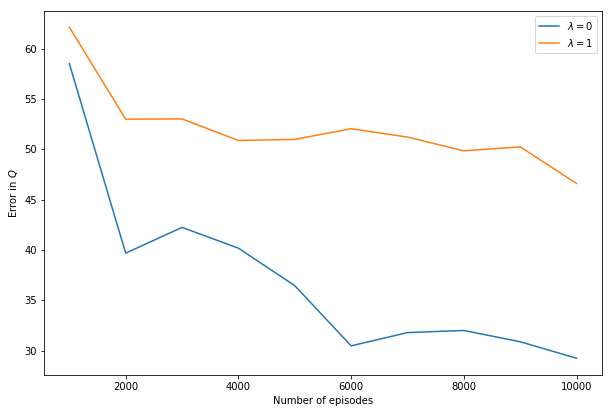

In [10]:
# plot up our results
fig, ax = plt.subplots(1, 1, figsize=(10, 6.7))

for lambda_ in (0, 1):
    x = np.arange(1000, 11000, 1000)
    y = results_df.loc[lambda_, :].tolist()
    _ = ax.plot(x, y, label = f"$\lambda = {round(lambda_, 1)}$")
    
_ = ax.legend()
_ = ax.set_xlabel("Number of episodes")
_ = ax.set_ylabel("Error in $Q$")

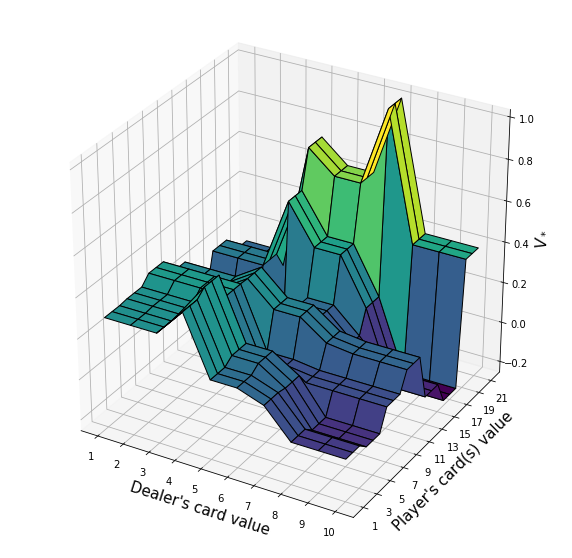

In [11]:
random.seed(0)

feature_vector = play_SARSA_linear(10 ** 5)

plotter = StatesPlotter(feature_vector.as_states())
_ = plotter.plot_value_function()